# How to use Tempered SMC to improve exploration of MCMC methods.
Multimodal distributions are typically hard to sample from, in particular using energy based methods such as HMC,
as you need high energy levels to escape a potential well. Tempered SMC helps with this by considering a sequence of
distributions $p_{\lambda_k}(x) \propto p_0(x) \exp(-\lambda_k V(x))$.

## Imports


In [19]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal

from blackjax.hmc import HMCParameters, kernel as hmc_kernel, new_state as hmc_state
from blackjax.nuts import NUTSParameters, kernel as nuts_kernel, new_state as nuts_state
from blackjax.tempered_smc import adaptive_tempered_smc, TemperedSMCState
from blackjax.inference.smc.resampling import systematic
from blackjax.inference.smc.smc import SMCState

## Experimental setup
We consider a prior distribution $p_0(x) = \mathcal{N}(x \mid 0_2, I_2)$ and a potential function $V(x) = (||x||^2 - 1)^2$
This corresponds to the following distribution:

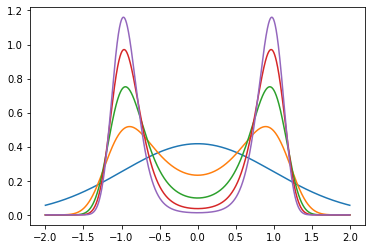

In [20]:
def V(x):
    return 5 * jnp.square(jnp.sum(x ** 2) - 1)


def prior_log_prob(x):
    d = x.shape[0]
    return multivariate_normal.logpdf(x, jnp.zeros((d,)), jnp.eye(d))


linspace = jnp.linspace(-2, 2, 5000).reshape(-1, 1)
lambdas = jnp.linspace(0., 1., 5)
prior_logvals = jnp.vectorize(prior_log_prob, signature="(d)->()")(linspace)
potential_vals = jnp.vectorize(V, signature="(d)->()")(linspace)
log_res = prior_logvals.reshape(1, -1) - jnp.expand_dims(lambdas, 1) * potential_vals.reshape(1, -1)

density = jnp.exp(log_res)
normalizing_factor = jnp.sum(density, axis=1, keepdims=True) * (linspace[1] - linspace[0])
density /= normalizing_factor

_ = plt.plot(linspace.squeeze(), density.T)

In [21]:
def full_potential(x):
    return V(x) - prior_log_prob(x)


inv_mass_matrix = jnp.eye(1)
n_samples = 5000

## HMC

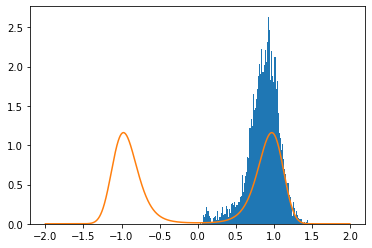

In [22]:
def inference_loop(rng_key, mcmc_kernel, initial_state, num_samples):
    def one_step(state, k):
        state, _ = mcmc_kernel(k, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


key = jax.random.PRNGKey(42)

hmc_kernel_instance = jax.jit(hmc_kernel(full_potential, HMCParameters(inv_mass_matrix=inv_mass_matrix)))
initial_hmc_state = hmc_state(jnp.ones((1,)), full_potential)
hmc_samples = inference_loop(key, hmc_kernel_instance, initial_hmc_state, n_samples)

_ = plt.hist(hmc_samples.position[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

## NUTS

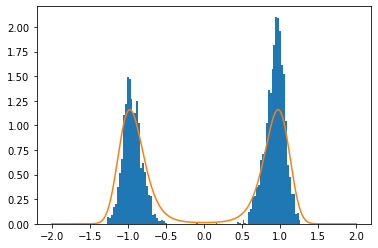

In [23]:
nuts_kernel_instance = jax.jit(nuts_kernel(full_potential, NUTSParameters(inv_mass_matrix=inv_mass_matrix)))
initial_nuts_state = nuts_state(jnp.ones((1,)), full_potential)
nuts_samples = inference_loop(key, nuts_kernel_instance, initial_nuts_state, n_samples)

_ = plt.hist(nuts_samples.position[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])

## Tempered SMC

Number of steps in the adaptive algorithm:  2


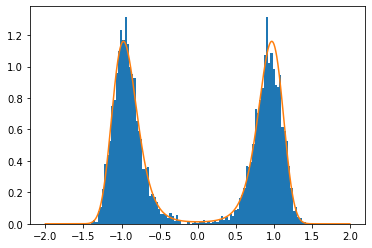

In [24]:
mcmc_kernel_factory = lambda pot_fun: hmc_kernel(pot_fun, HMCParameters(inv_mass_matrix=inv_mass_matrix))
smc_kernel_instance = jax.jit(adaptive_tempered_smc(prior_log_prob, V, mcmc_kernel_factory, hmc_state, systematic, 0.5, mcmc_iter=1))
initial_smc_state = SMCState(jax.random.multivariate_normal(jax.random.PRNGKey(0),
                                                            jnp.zeros([1]),
                                                            jnp.eye(1),
                                                            (n_samples,)))
initial_smc_state = TemperedSMCState(0, initial_smc_state, 0.)

def smc_inference_loop(rng_key, smc_kernel, initial_state):

    def cond(carry):
        state, _k = carry
        return state.lamda < 1

    def one_step(carry):
        state, k = carry
        k, subk = jax.random.split(k, 2)
        state, _ = smc_kernel(subk, state)
        return state, k

    final_state, _ = jax.lax.while_loop(cond, one_step, (initial_state, rng_key))

    return final_state


smc_samples = smc_inference_loop(key, smc_kernel_instance, initial_smc_state)
print("Number of steps in the adaptive algorithm: ", smc_samples.n_iter)
_ = plt.hist(smc_samples.smc_state.particles[:, 0], bins=100, density=True)
_ = plt.plot(linspace.squeeze(), density[-1])
